<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/SARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/oilPrice.csv', parse_dates = ['DATE'])
df = df.set_index('DATE')
df = df.rename(columns = {'DCOILBRENTEU':'price'})

Text(0.5, 1.0, 'Daily oil price')

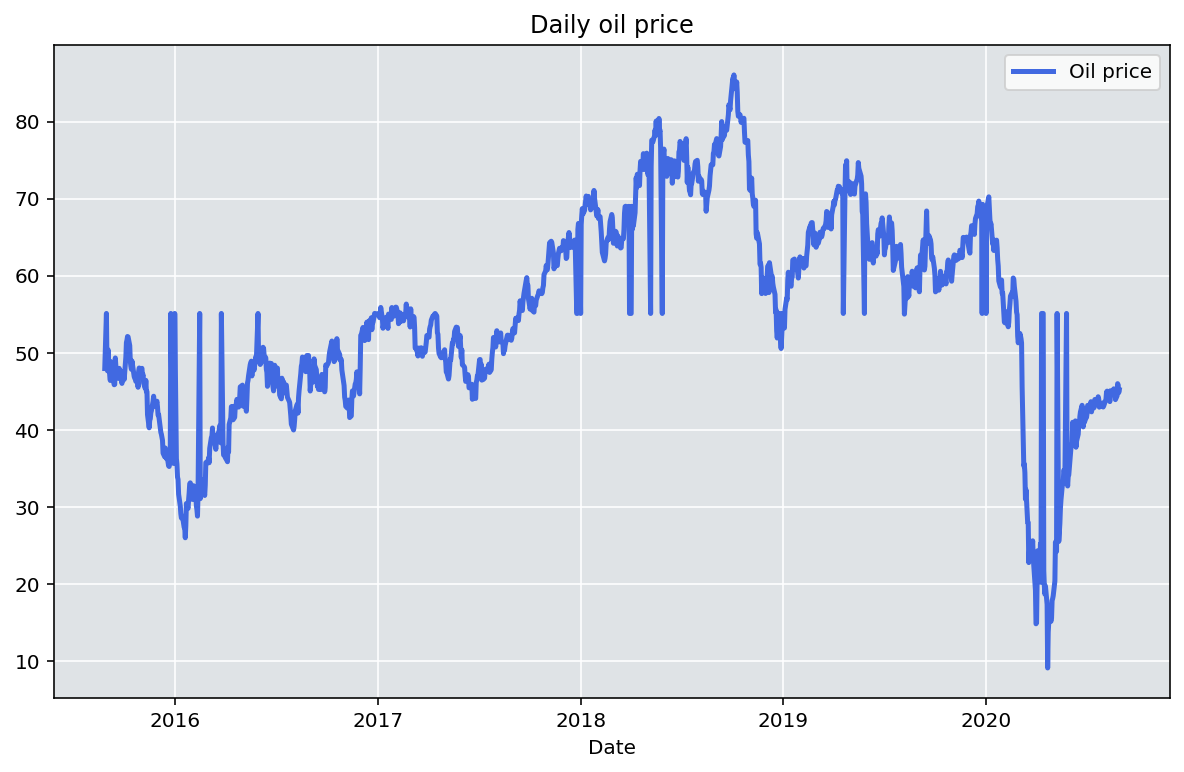

In [3]:
# Data assessment
df['price'] = df['price'].replace('.', np.nan)
df['price'] = df['price'].astype(np.float64)
df['price'] = df['price'].fillna(df['price'].mean())

# Plotting price
plt.figure(figsize = (10,6))
ax = plt.axes()
ax.set_facecolor('#dfe3e6')
plt.grid(color = 'w')
plt.plot(df['price'], c = 'royalblue', linewidth = 2.5, label = 'Oil price')
plt.xlabel('Date')
plt.legend()
plt.title('Daily oil price')

In [4]:
# Grid search parameters
p = d = q = range(0, 3) #pdq can be either 0 or 1 or 2
P = D = Q = range(0, 3) #PDQ can be either 0 or 1 or 2
seasonal = 7 #Define seasonal parameter (weekly)

# All possible combiantions
pdq = list(itertools.product(p, d, q))
PDQ = list(itertools.product(P, D, Q))
PDQS = [(a[0], a[1], a[2], seasonal) for a in PDQ] #With seasonal effect

In [5]:
# Grid search model
aic = None

for trends in pdq:
  for seasons in PDQS:
    model = SARIMAX(df['price'], order = trends, seasonal_order = seasons,
                    enforce_stationarity = False, enforce_invertibility = False, freq = 'B')
    model = model.fit()
    if aic is None:
      aic = model.aic
    elif aic > model.aic:
      aic = model.aic
      best_pdq = trends
      best_PDQS = seasons
      print(f'Lowest AIC: {aic}')
      print(f'Best p, d, q: {trends}')
      print(f'Best P, D, Q, S: {seasons}')
    else:
      continue

Lowest AIC: 12598.119213877497
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 0, 1, 7)
Lowest AIC: 11369.736113274297
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 0, 2, 7)
Lowest AIC: 7905.79099687616
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 1, 0, 7)
Lowest AIC: 7797.682845573626
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 1, 1, 7)
Lowest AIC: 7761.505580476805
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 1, 2, 7)
Lowest AIC: 7758.447505002584
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (0, 2, 2, 7)
Lowest AIC: 7757.5839611753645
Best p, d, q: (0, 0, 0)
Best P, D, Q, S: (2, 1, 2, 7)
Lowest AIC: 7530.2233378233
Best p, d, q: (0, 0, 1)
Best P, D, Q, S: (0, 1, 0, 7)
Lowest AIC: 7325.999193909402
Best p, d, q: (0, 0, 1)
Best P, D, Q, S: (0, 1, 1, 7)
Lowest AIC: 7294.0822732886845
Best p, d, q: (0, 0, 1)
Best P, D, Q, S: (0, 1, 2, 7)
Lowest AIC: 7292.887595083104
Best p, d, q: (0, 0, 1)
Best P, D, Q, S: (0, 2, 2, 7)
Lowest AIC: 7210.891591755172
Best p, d, q: (0, 0, 2)
Best P, D, Q, S: (0, 

In [6]:
# Fitting model
model = SARIMAX(df['price'], order = best_pdq, seasonal_order = best_PDQS,
                enforce_stationarity = False, enforce_invertibility = False, freq = 'B')
model = model.fit()

In [7]:
# Prediction
pred = model.predict()
df['predict'] = pred
df['predict'][0] = df['price'][0] #Fix missing first prediction date due to first different

Text(0.5, 1.0, 'Back testing')

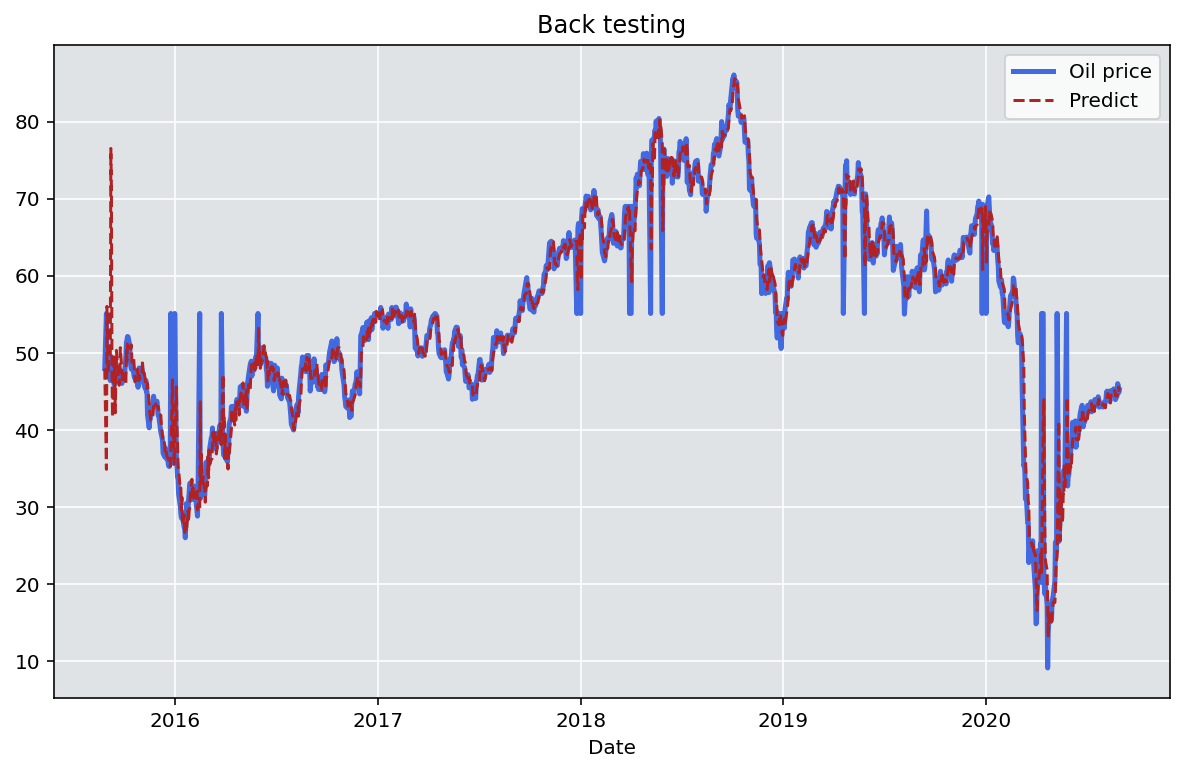

In [8]:
# Back testing
plt.figure(figsize = (10,6))
ax = plt.axes()
ax.set_facecolor('#dfe3e6')
plt.grid(color = 'w')
plt.plot(df['price'], c = 'royalblue', linewidth = 2.5, label = 'Oil price')
plt.plot(df['predict'], c = 'firebrick', linestyle = '--', label = 'Predict')
plt.xlabel('Date')
plt.legend()
plt.title('Back testing')

Text(0.5, 1.0, 'Forecast with confidence interval')

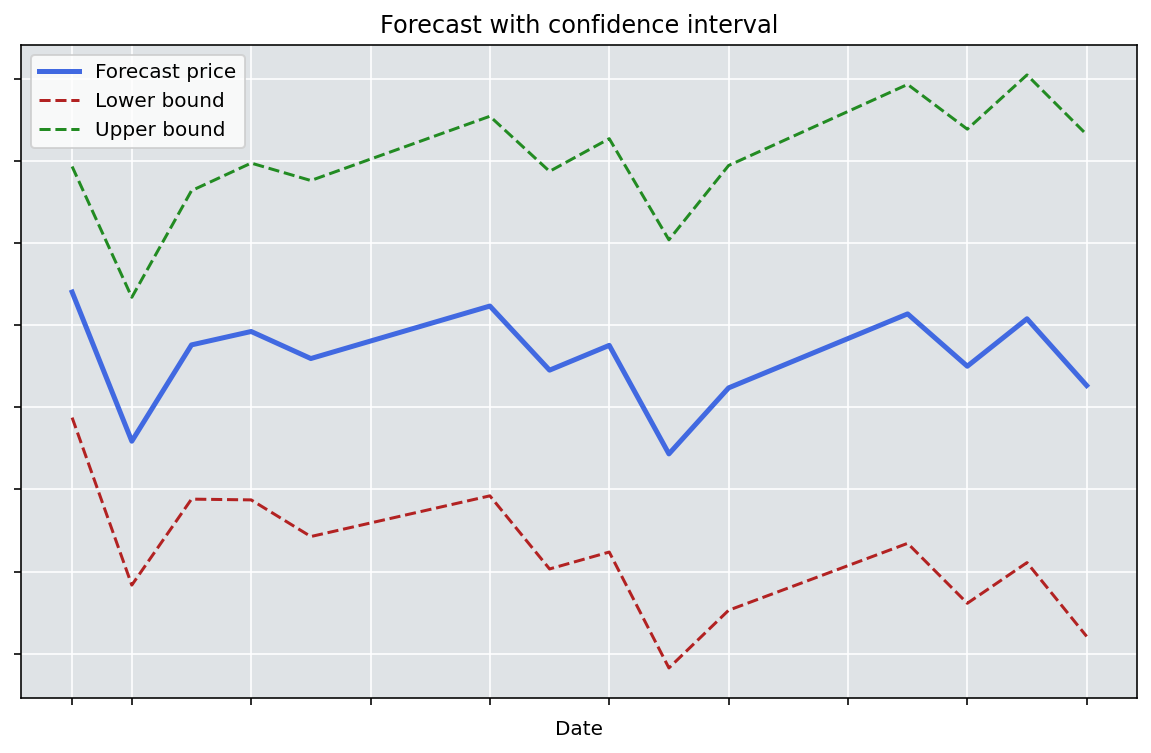

In [9]:
# Forecasting
forecast_ci = model.get_forecast(steps = 14) #2 Week ahead
forecast_ci = forecast_ci.conf_int(alpha = 0.90) #90% Confidence level
forecast_ci['price'] = model.forecast(steps = 14)

plt.figure(figsize = (10,6))
ax = plt.axes()
ax.set_facecolor('#dfe3e6')
plt.grid(color = 'w')
plt.plot(forecast_ci['price'], c = 'royalblue', linewidth = 2.5, label = 'Forecast price')
plt.plot(forecast_ci['lower price'], c = 'firebrick', linestyle = '--', label = 'Lower bound')
plt.plot(forecast_ci['upper price'], c = 'forestgreen', linestyle = '--', label = 'Upper bound')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.xlabel('Date')
plt.legend()
plt.title('Forecast with confidence interval')

The oil price in the next 2 weeks is: 45.06608756080212


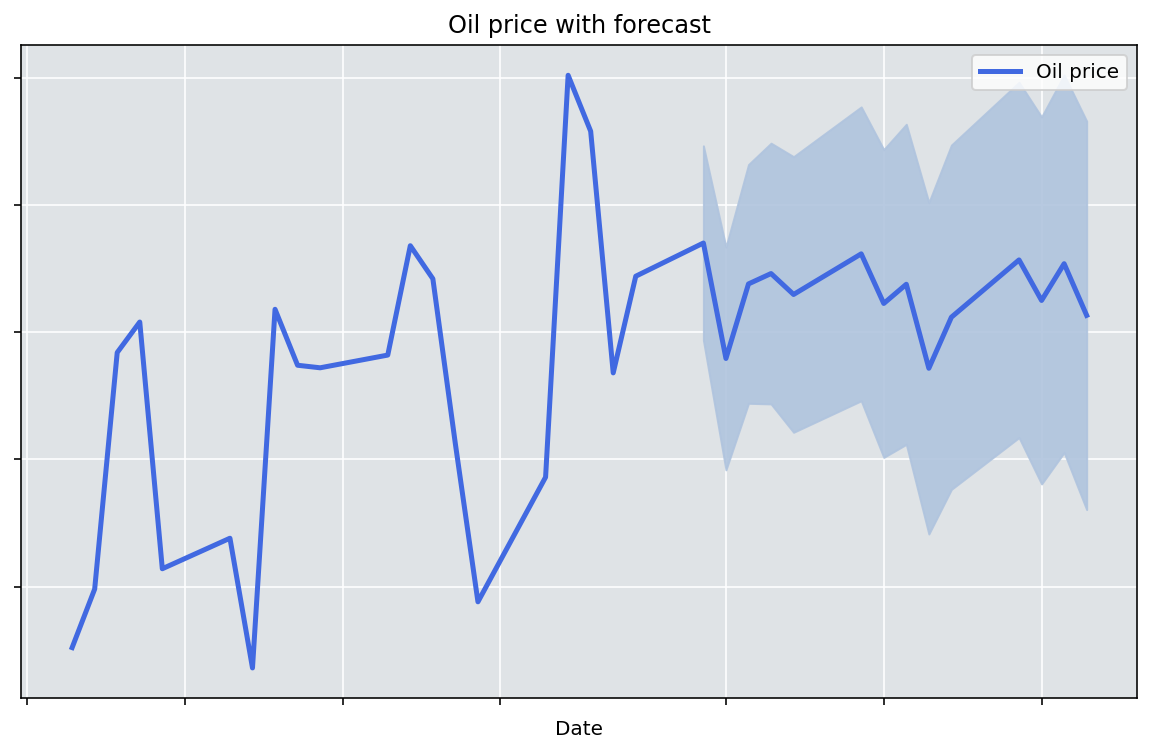

In [10]:
# Combine with actual data
df_forecast = pd.concat([df.loc['2020-08']['price'], model.forecast(steps = 14)], axis = 0)
# Use data since Aug-2020 onward

# Plot with confidence interval
plt.figure(figsize = (10,6))
ax = plt.axes()
ax.set_facecolor('#dfe3e6')
plt.grid(color = 'w')
plt.plot(df_forecast, c = 'royalblue', linewidth = 2.5, label = 'Oil price')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                 color = 'lightsteelblue', alpha = 0.90, zorder = 2)
plt.xlabel('Date')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.legend()
plt.title('Oil price with forecast')

#Get the lastest forecast price
print(f'The oil price in the next 2 weeks is: {df_forecast[-1]}')